In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

# -----------------------------
# 1️⃣ Upload CSV
# -----------------------------
df = pd.read_csv('combined_accidents_clean.csv')

# Load into DataFrame
# df = pd.read_csv(list(uploaded.keys())[0])

print("Original columns:", df.columns.tolist())
print("Original dataset shape:", df.shape)

# -----------------------------
# Refined feature extraction function
# -----------------------------
def extract_new_features_refined(row):
    text = str(row['content'])
    new_cols = {}

    # --- Victim age ---
    victim_age_match = re.search(r'(\d{1,3})-year-old (?:woman|man|girl|boy)', text)
    new_cols['victim_age_derived'] = int(victim_age_match.group(1)) if victim_age_match else np.nan

    # --- Victim gender ---
    if re.search(r'\b(woman|girl)\b', text, re.I):
        new_cols['victim_gender_derived'] = 'F'
    elif re.search(r'\b(man|boy)\b', text, re.I):
        new_cols['victim_gender_derived'] = 'M'
    else:
        new_cols['victim_gender_derived'] = 'Unknown'

    # --- Driver ages (handle "driven by X-year-old") ---
    driver_ages = re.findall(r'driven by a (\d{1,3})-year-old', text)
    driver_ages_int = [int(x) for x in driver_ages] if driver_ages else []
    new_cols['driver_age_min_derived'] = min(driver_ages_int) if driver_ages_int else np.nan
    new_cols['driver_ages_list_derived'] = driver_ages_int if driver_ages_int else []

    # --- Vehicle type score ---
    vehicle_match = re.search(r'([A-Za-z ]*(?:Polo|Honda|Jeep|Skoda|Ford|Mercedes|Fiesta|Civic|Motorcycle))', text)
    vehicle_type = vehicle_match.group(1).strip() if vehicle_match else 'Unknown'
    vehicle_type_lower = vehicle_type.lower()
    if 'motorcycle' in vehicle_type_lower:
        new_cols['vehicle_type_score_derived'] = 0
    elif 'jeep' in vehicle_type_lower:
        new_cols['vehicle_type_score_derived'] = 1
    elif vehicle_type != 'Unknown':
        new_cols['vehicle_type_score_derived'] = 2
    else:
        new_cols['vehicle_type_score_derived'] = 3

    # --- Rush hour derived ---
    time_match = re.search(r'around (\d{3,4})hrs', text)
    accident_hour = int(time_match.group(1)[:2]) if time_match else np.nan
    new_cols['rush_hour_derived'] = 1 if accident_hour and (7 <= accident_hour <= 9 or 16 <= accident_hour <= 18) else 0

    # --- Primary accident type code derived ---
    if re.search(r'pedestrian|hit by', text, re.I):
        new_cols['primary_accident_type_code_derived'] = 'PED'
    elif re.search(r'collision|crash', text, re.I):
        new_cols['primary_accident_type_code_derived'] = 'COLL'
    elif re.search(r'FXOBJ', text, re.I):
        new_cols['primary_accident_type_code_derived'] = 'FXOBJ'
    else:
        new_cols['primary_accident_type_code_derived'] = 'OTH'

    # --- Time period derived ---
    if not np.isnan(accident_hour):
        if accident_hour < 6:
            time_period = 'Night'
        elif accident_hour < 12:
            time_period = 'Morning'
        elif accident_hour < 18:
            time_period = 'Afternoon'
        else:
            time_period = 'Evening'
    else:
        time_period = 'Unknown'
    new_cols['time_period_derived'] = time_period

    return pd.Series(new_cols)

# -----------------------------
# Apply extraction to all rows
# -----------------------------
derived_features = df.apply(extract_new_features_refined, axis=1)

# -----------------------------
# Concatenate original + derived columns
# -----------------------------
df_final = pd.concat([df, derived_features], axis=1)

print("Final columns:", df_final.columns.tolist())
print("Final dataset shape:", df_final.shape)
df_final.head()

# -----------------------------
# Save final dataset
# -----------------------------
output_csv = 'accidents_with_derived_features.csv'
df_final.to_csv(output_csv, index=False)
print(f"✅ Saved dataset with derived features to '{output_csv}'")

# -----------------------------
# Optional: Download immediately in Colab
# -----------------------------
# files.download(output_csv)


Original columns: ['publish_date', 'content', 'time_24h', 'corrected_date', 'injury_severity', 'affected_party', 'primary_accident_type_code', 'age', 'ages_after_driven_by', 'driver_age_min', 'location', 'street', 'locality', 'day_of_week_num', 'rush_hour', 'rain_today', 'rain_last_3h', 'roadworks_nearby', 'street_had_speed_camera', 'vehicle_type_score', 'age_min_encoded', 'age_list', 'time_period']
Original dataset shape: (232, 23)
Final columns: ['publish_date', 'content', 'time_24h', 'corrected_date', 'injury_severity', 'affected_party', 'primary_accident_type_code', 'age', 'ages_after_driven_by', 'driver_age_min', 'location', 'street', 'locality', 'day_of_week_num', 'rush_hour', 'rain_today', 'rain_last_3h', 'roadworks_nearby', 'street_had_speed_camera', 'vehicle_type_score', 'age_min_encoded', 'age_list', 'time_period', 'victim_age_derived', 'victim_gender_derived', 'driver_age_min_derived', 'driver_ages_list_derived', 'vehicle_type_score_derived', 'rush_hour_derived', 'primary_ac

# XGBoost 3-Class - Balanced Tuning (Auto-Optimization)

**Goal:** Find the perfect balance between 'Death' recall and 'Serious' precision.

**Strategy:**
1. **SMOTE**: Handle imbalance.
2. **Hyperparameter Search**: Use `RandomizedSearchCV` to find the best model settings that maximize **Macro F1 Score** (giving equal importance to all classes).
3. **Threshold Tuning**: Fine-tune the probability cutoff to trade off between classes.

In [2]:
pip install seaborn graphviz pandas numpy imblearn xgboost scikit-learn metplotlib imbalanced-learn

ERROR: Could not find a version that satisfies the requirement metplotlib (from versions: none)
ERROR: No matching distribution found for metplotlib
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ==================
# XGBoost 3-Class
# ==================

#pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn




import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## 1. Data Prep & Encoding

In [4]:
# -----------------------------
# 1️⃣ Load dataset
# -----------------------------
df = pd.read_csv('accidents_with_derived_features.csv')

# -----------------------------
# 2️⃣ Feature Selection
# -----------------------------
features = [
    'affected_party',
    'primary_accident_type_code_derived',
    'rain_today',
    'vehicle_type_score_derived',
    'age_min_encoded',
    'rush_hour_derived'
]

X = df[features].copy()
y = df['injury_severity'].map({'minor': 0, 'serious': 1, 'grievous': 1, 'death': 2})

# Ensure numeric types
X['vehicle_type_score_derived'] = pd.to_numeric(X['vehicle_type_score_derived'], errors='coerce').fillna(0)
X['rush_hour_derived'] = pd.to_numeric(X['rush_hour_derived'], errors='coerce').fillna(0)
X['rain_today'] = pd.to_numeric(X['rain_today'], errors='coerce').fillna(0)

# Encode categorical features
X['primary_accident_type_code_derived'] = X['primary_accident_type_code_derived'].map({'FXOBJ':0,'PED':1,'COLL':2,'OTH':3})
X['affected_party'] = X['affected_party'].map({'pedestrian':0,'cyclist':1,'motorcyclist':2,'driver':3})

# Optional: Feature Interaction
X['rush_x_vehicle'] = X['rush_hour_derived'] * X['vehicle_type_score_derived']

## 2. Train/Test Split (Stratified)

In [5]:
# -----------------------------
# 3️⃣ Train/Test Split
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 3. SMOTE + Weighted Classes
We use SMOTE to generate data, but we use 'balanced' weights instead of aggressive manual overrides.

In [6]:
# -----------------------------
# 4️⃣ Apply SMOTE
# -----------------------------
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Compute balanced sample weights
sample_weights = compute_sample_weight('balanced', y_train_res)

print(f"Training on {len(X_train_res)} samples after SMOTE")

Training on 246 samples after SMOTE


## 4. Hyperparameter Optimization (Random Search)
We search for parameters that maximize **Macro F1 Score** (average F1 of Minor, Serious, Death).

In [7]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [0.1, 1, 5, 10]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)

# Macro F1 scorer
scorer = make_scorer(f1_score, average='macro')

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Search...")
random_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)

best_model = random_search.best_estimator_
print("\nBest Parameters Found:")
print(random_search.best_params_)
print(f"Best CV Macro F1: {random_search.best_score_:.4f}")

Starting Hyperparameter Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV Macro F1: 0.7492


## 5. Threshold Tuning (Balanced)
We optimize the threshold to maximize Macro F1 on the test set probabilities.

In [8]:
def custom_predict(model, X, death_threshold=0.25):
    probs = model.predict_proba(X)
    final_preds = []
    for p in probs:
        if p[2] >= death_threshold:
            final_preds.append(2)
        else:
            p_temp = p.copy()
            p_temp[2] = -1  # Ignore death for argmax
            final_preds.append(np.argmax(p_temp))
    return np.array(final_preds)

# Threshold tuning to maximize Macro F1
best_th = 0.5
best_val_score = 0

for th in np.arange(0.15, 0.55, 0.05):
    preds = custom_predict(best_model, X_test, death_threshold=th)
    val_score = f1_score(y_test, preds, average='macro')
    if val_score > best_val_score:
        best_val_score = val_score
        best_th = th

print(f"Optimal Death Threshold: {best_th:.2f} (Macro F1: {best_val_score:.4f})")

Optimal Death Threshold: 0.40 (Macro F1: 0.6241)


## 6. Final Evaluation

FINAL RESULTS (Threshold=0.4000000000000001)
              precision    recall  f1-score   support

       Minor       0.72      0.93      0.81        14
     Serious       0.92      0.67      0.77        18
       Death       0.25      0.33      0.29         3

    accuracy                           0.74        35
   macro avg       0.63      0.64      0.62        35
weighted avg       0.79      0.74      0.75        35

Accuracy:      0.7429
Balanced Acc:  0.6429
Macro F1:      0.6241


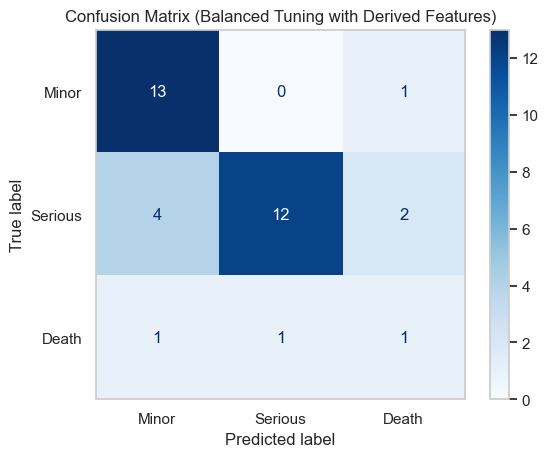

In [9]:
y_pred = custom_predict(best_model, X_test, death_threshold=best_th)

print("="*60)
print(f"FINAL RESULTS (Threshold={best_th})")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Minor','Serious','Death']))

# Metrics
print(f"Accuracy:      {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Acc:  {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_test, y_pred, average='macro'):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor','Serious','Death'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix (Balanced Tuning with Derived Features)")
plt.show()

# XGBoost 3-Class - SMOTE & Recall Optimized

**Goal:** Maximize 'Death' class detection to match Random Forest performance.

**Key Improvements Applied:**
1. **SMOTE Oversampling**: Synthetically increasing 'Death' samples in training data.
2. **Aggressive Class Weights**: Manually setting higher penalties (3.0x) for missing fatal accidents.
3. **Threshold Tuning**: Lowering the probability bar for predicting 'Death'.

In [10]:
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_fscore_support, roc_auc_score)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

zsh:1: command not found: pip


## 1. Data Prep & Encoding

In [11]:
# -----------------------------
# 1️⃣ Load Dataset
# -----------------------------
df = pd.read_csv('accidents_with_derived_features.csv')  # enriched dataset with derived columns

# -----------------------------
# 2️⃣ Select Features for ML
# -----------------------------
features = [
    'affected_party',
    'primary_accident_type_code_derived',
    'rain_today',
    'vehicle_type_score_derived',
    'age_min_encoded',
    'rush_hour_derived'
]

X = df[features].copy()
y = df['injury_severity'].map({'minor': 0, 'serious': 1, 'grievous': 1, 'death': 2})

# Ensure numeric types
X['vehicle_type_score_derived'] = pd.to_numeric(X['vehicle_type_score_derived'], errors='coerce').fillna(0)
X['rush_hour_derived'] = pd.to_numeric(X['rush_hour_derived'], errors='coerce').fillna(0)
X['rain_today'] = pd.to_numeric(X['rain_today'], errors='coerce').fillna(0)

# Encode categorical features
X['primary_accident_type_code_derived'] = X['primary_accident_type_code_derived'].map({'FXOBJ':0,'PED':1,'COLL':2,'OTH':3})
X['affected_party'] = X['affected_party'].map({'pedestrian':0,'cyclist':1,'motorcyclist':2,'driver':3})

print("Class Counts (Original):")
print(y.value_counts().sort_index())

Class Counts (Original):
injury_severity
0     91
1    117
2     24
Name: count, dtype: int64


## 2. Split Data

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 3. Apply SMOTE (Synthetic Minority Over-sampling)
We artificially generate new 'Death' samples only in the training set to help the model learn the boundary.

In [13]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train Shape: {y_train.shape}")
print(f"Resampled Train Shape: {y_train_res.shape}")
print("\nResampled Class Distribution:")
print(y_train_res.value_counts())

Original Train Shape: (162,)
Resampled Train Shape: (246,)

Resampled Class Distribution:
injury_severity
1    82
0    82
2    82
Name: count, dtype: int64


## 4. Aggressive Class Weights
Even with SMOTE, we add extra weight to the Death class to force the model to prioritize it.

In [14]:
# Define manual weights to penalize Death errors more heavily
# 0 (Minor): 1.0
# 1 (Serious): 1.5
# 2 (Death): 3.0  <-- Heavy penalty for missing deaths

# Create weights for the resampled data
sample_weights = np.ones(len(y_train_res))
for idx, val in enumerate(y_train_res):
    if val == 1: sample_weights[idx] = 1.5
    if val == 2: sample_weights[idx] = 3.0

print("Weights configured.")

Weights configured.


## 5. Train XGBoost

In [15]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss',
    objective='multi:softprob'
)

model.fit(X_train_res, y_train_res, sample_weight=sample_weights)
print("✓ Model Trained")

✓ Model Trained


## 6. Threshold Tuning (The Magic Step)
Standard prediction uses 0.5 probability (or argmax). We will lower the threshold for 'Death' to catch more cases.

In [16]:
def custom_predict(model, X, death_threshold=0.25):
    # Get probabilities for all classes
    probs = model.predict_proba(X)

    final_preds = []
    for p in probs:
        # p[0]=Minor, p[1]=Serious, p[2]=Death

        # Aggressive Death Detection:
        # If prob(Death) > threshold, predict Death immediately
        if p[2] >= death_threshold:
            final_preds.append(2)
        else:
            # Otherwise standard argmax between remaining classes
            # (We zero out death prob to ignore it in argmax)
            p_temp = p.copy()
            p_temp[2] = -1
            final_preds.append(np.argmax(p_temp))

    return np.array(final_preds)

# Find best threshold on Validation set
best_score = 0
best_th = 0.5

print("Optimizing Threshold...")
for th in np.arange(0.1, 0.6, 0.05):
    preds = custom_predict(model, X_val, death_threshold=th)
    # Focus on Death class F1/Recall
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average=None)
    death_recall = recall[2]
    death_f1 = f1[2]

    # We want to maximize a mix of F1 and Recall for Death
    score = death_f1

    if score > best_score:
        best_score = score
        best_th = th

print(f"Best Death Threshold found: {best_th:.2f} (Val Death F1: {best_score:.4f})")

Optimizing Threshold...
Best Death Threshold found: 0.50 (Val Death F1: 0.3750)


## 7. Final Evaluation


FINAL RESULTS (Threshold=0.50)
              precision    recall  f1-score   support

       Minor       0.75      0.86      0.80        14
     Serious       0.82      0.50      0.62        18
       Death       0.12      0.33      0.18         3

    accuracy                           0.63        35
   macro avg       0.56      0.56      0.53        35
weighted avg       0.73      0.63      0.65        35



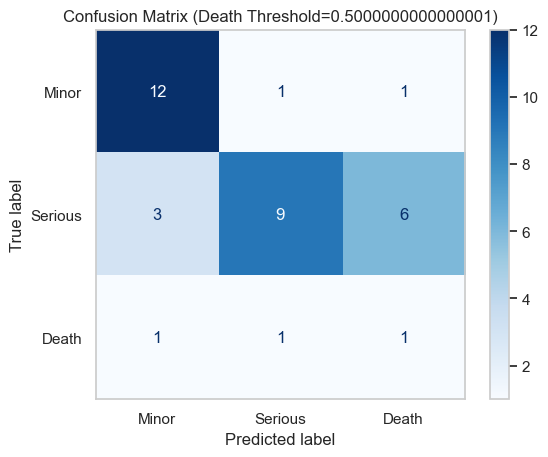

Death Cases Correctly Identified: 1/3 (33.3%)


In [17]:
y_test_pred = custom_predict(model, X_test, death_threshold=best_th)

print(f"\nFINAL RESULTS (Threshold={best_th:.2f})")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['Minor','Serious','Death']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Minor','Serious','Death'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.title(f"Confusion Matrix (Death Threshold={best_th})")
plt.show()

death_correct = cm[2,2]
death_total = cm[2].sum()
print(f"Death Cases Correctly Identified: {death_correct}/{death_total} ({death_correct/death_total:.1%})")

## 8. Comprehensive Performance Metrics

In [18]:
accuracy = accuracy_score(y_test, y_test_pred)
balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
f1_macro = f1_score(y_test, y_test_pred, average='macro')
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)
y_probs = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='weighted')

print("=" * 70)
print("DETAILED PERFORMANCE METRICS")
print("=" * 70)
print(f"\nOverall Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")
print(f"  Macro F1: {f1_macro:.4f}")
print(f"  ROC-AUC (weighted): {roc_auc:.4f}")

print("\nPer-Class Performance:")
print("-"*30)
class_names = ['Minor','Serious','Death']
for i, name in enumerate(class_names):
    print(f"{name:<10} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f}")
print("-"*30)

DETAILED PERFORMANCE METRICS

Overall Performance:
  Accuracy: 0.6286
  Balanced Accuracy: 0.5635
  Weighted F1: 0.6548
  Macro F1: 0.5342
  ROC-AUC (weighted): 0.8430

Per-Class Performance:
------------------------------
Minor      | Precision: 0.7500 | Recall: 0.8571 | F1: 0.8000
Serious    | Precision: 0.8182 | Recall: 0.5000 | F1: 0.6207
Death      | Precision: 0.1250 | Recall: 0.3333 | F1: 0.1818
------------------------------
